In [ ]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=KhcIXmGB9qiqYSurmEd1OE7ai1gsoY&access_type=offline&code_challenge=FXd8t_iNJ1Smwus7s7YNkiZ2VgOos-bXrFHWGHwaAs8&code_challenge_method=S256


Credentials saved to file: [/Users/yt4/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "open-targets-genetics-dev" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [ ]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=UiDTZiS2COSkwLlSyy0l1pVKoF8Yfg&access_type=offline&code_challenge=4jMAWGLzSEe-ozTnSiVWYKCSv6hg9PyZzX727eiHbYk&code_challenge_method=S256


You are now logged in as [yt4@sanger.ac.uk].
Your current project is [open-targets-genetics-dev].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update



In [1]:
import os

import hail as hl
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql import DataFrame

from gentropy.common.session import Session
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.dataset.study_locus import StudyLocus
from gentropy.susie_finemapper import SusieFineMapperStep
from gentropy.method.drug_enrichment_from_evid import chemblDrugEnrichment

"""Common utilities for the project."""

import os
from pathlib import Path
from gentropy.common.session import Session
import logging


def get_gcs_credentials() -> str:
    """Get the credentials for google cloud storage."""
    app_default_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/application_default_credentials.json"
    )

    service_account_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/service_account_credentials.json"
    )

    if Path(app_default_credentials).exists():
        return app_default_credentials
    else:
        raise FileNotFoundError("No GCS credentials found.")


def get_gcs_hadoop_connector_jar() -> str:
    """Get the google cloud storage hadoop connector for spark.

    This function will return the url to download the hadoop jar.
    """

    return (
        "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar"
    )


def gcs_conf(
    credentials_path=None, project="open-targets-genetics-dev"
) -> dict[str, str]:
    """Get the spark configuration with hadoop connector for google cloud storage."""
    credentials_path = credentials_path or get_gcs_credentials()
    return {
        "spark.driver.memory": "12g",
        "spark.kryoserializer.buffer.max": "500m",
        "spark.driver.maxResultSize":"2g",
        "spark.hadoop.fs.gs.impl": "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem",
        "spark.jars": get_gcs_hadoop_connector_jar(),
        "spark.hadoop.google.cloud.auth.service.account.enable": "true",
        "spark.hadoop.fs.gs.project.id": project,
        "spark.hadoop.google.cloud.auth.service.account.json.keyfile": credentials_path,
        "spark.hadoop.fs.gs.requester.pays.mode": "AUTO",
    }


class GentropySession(Session):
    def __init__(self, *args, **kwargs):
        if "extended_spark_conf" in kwargs:
            kwargs["extended_spark_conf"].update(gcs_conf())
        else:
            kwargs["extended_spark_conf"] = gcs_conf()
        super().__init__(*args, **kwargs)

    @property
    def conf(self):
        logging.warning(
            "To change the config restart the session and use the `extended_spark_conf` parameter."
        )
        return self.spark.sparkContext.getConf().getAll()

session= GentropySession()


path_to_release_folder="gs://open-targets-data-releases/25.03/"
#path_to_release_folder="gs://open-targets-pre-data-releases/24.12-uo_test-3/output/genetics/parquet/"
#path_to_release_folder="gs://ot_orchestration/releases/25.02_freeze1/"

si=StudyIndex.from_parquet(session,path_to_release_folder+"output/study/")
sl=StudyLocus.from_parquet(session,path_to_release_folder+"output/credible_set/")

Loading BokehJS ...

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/24 22:55:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/24 22:55:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# trans pQTL evidence

In [2]:
trans_pqt=session.spark.read.parquet("gs://genetics-portal-dev-analysis/dc16/output/trans_pqtl_colocs.parquet")

In [3]:
trans_pqt.count()

3509383

In [4]:
trans_pqt.filter((f.col("isTransQtl")==True)&((f.col("clpp")>=0.01)|(f.col("h4")>=0.8))).count()

3509383

In [5]:
trans_pqt.show(1)

+--------------------+--------------------+--------------+----------+--------------------+--------------------------+----+----+----+----+----+----+--------------------+--------------------+----------+------------+
|    leftStudyLocusId|   rightStudyLocusId|rightStudyType|chromosome|colocalisationMethod|numberColocalisingVariants|  h0|  h1|  h2|  h3|  h4|clpp|betaRatioSignAverage|    transPQTLStudyId|isTransQtl| leftStudyId|
+--------------------+--------------------+--------------+----------+--------------------+--------------------------+----+----+----+----+----+----+--------------------+--------------------+----------+------------+
|00054cbf4912bfa67...|812612a2ed4564652...|          pqtl|        11|             eCAVIAR|                         1|NULL|NULL|NULL|NULL|NULL| 1.0|                 1.0|UKB_PPP_EUR_MSTN_...|      true|GCST90078909|
+--------------------+--------------------+--------------+----------+--------------------+--------------------------+----+----+----+----+----+--

In [6]:
trans_pqt=trans_pqt.select("leftStudyLocusId","rightStudyLocusId","transPQTLStudyId","leftStudyId").distinct().cache()
trans_pqt.count()

2303537

In [7]:
trans_pqt = (trans_pqt.join(
    si.df.select("studyId","geneId"),  # Select only the necessary column from si.df
    trans_pqt["transPQTLStudyId"] == si.df["studyId"],  # Join condition
    how="inner"
).select("leftStudyLocusId","leftStudyId","geneId")
.withColumnRenamed("leftStudyLocusId","studyLocusId")
.withColumnRenamed("leftStudyId","studyId")
.withColumn("trans_pQTL_Score", f.lit(1))
.cache())

In [8]:
trans_pqt.count()

2303537

In [9]:
trans_pqt.show(1)

+--------------------+------------+---------------+----------------+
|        studyLocusId|     studyId|         geneId|trans_pQTL_Score|
+--------------------+------------+---------------+----------------+
|0040e872d53bb8393...|GCST90249387|ENSG00000089248|               1|
+--------------------+------------+---------------+----------------+
only showing top 1 row



In [10]:
trsn_pqtls_evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=trans_pqt,
    score_column="trans_pQTL_Score",
    datasource_id="trans_pQTLs",
    study_locus=sl,
    study_index=si,
    min_score=1
).cache()

In [11]:
trsn_pqtls_evidence.count()

2710381

In [12]:
trsn_pqtls_evidence=trsn_pqtls_evidence.distinct().cache()

In [13]:
trsn_pqtls_evidence.count()

2654813

In [14]:
import pandas as pd
all_enrich = []

In [16]:
disease_index_path=path_to_release_folder+"output/disease/disease.parquet"
disease_index_orig = session.spark.read.parquet(disease_index_path)

platform_chembl_evidence_path=path_to_release_folder+"output/evidence/sourceId=chembl"
chembl_evidence=session.spark.read.parquet(platform_chembl_evidence_path)

In [17]:
#trans_pQTLs
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=trsn_pqtls_evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence, 
    indirect_assoc_score_thr=0.5,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = "trans_pQTL"
all_enrich.append(enrich)

## interaction with cis

In [18]:
# trans pqt interactions
inter=session.spark.read.parquet("gs://open-targets-pre-data-releases/partners/24.12/output/etl/parquet/interaction")
inter.show(1)

+--------------+---------------+---------------+------------------+---------------+---------------+------------------+--------------------+--------------------+-----+-------+
|sourceDatabase|        targetA|           intA|intABiologicalRole|        targetB|           intB|intBBiologicalRole|            speciesA|            speciesB|count|scoring|
+--------------+---------------+---------------+------------------+---------------+---------------+------------------+--------------------+--------------------+-----+-------+
|        string|ENSG00000004059|ENSP00000000233|  unspecified role|ENSG00000105443|ENSP00000493357|  unspecified role|{human, Homo sapi...|{human, Homo sapi...|    3|  0.471|
+--------------+---------------+---------------+------------------+---------------+---------------+------------------+--------------------+--------------------+-----+-------+
only showing top 1 row



In [19]:
inter.groupBy("sourceDatabase").count().show()

+--------------+--------+
|sourceDatabase|   count|
+--------------+--------+
|        string|13218902|
|        intact| 1113884|
|        signor|   36379|
|      reactome|   52972|
+--------------+--------+



In [20]:
inter=inter.filter((f.col("sourceDatabase")=="string")&(f.col("scoring")>=0.8)).select("targetA","targetB").distinct().cache()
inter.count()

317496

In [ ]:
#inter.repartition(1).write.csv("gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/interactions_005.csv", header=True, mode="overwrite")

In [21]:
inter.show(1)

+---------------+---------------+
|        targetA|        targetB|
+---------------+---------------+
|ENSG00000153774|ENSG00000163159|
+---------------+---------------+
only showing top 1 row



In [22]:
trsn_pqtls_evidence.show(1)

+----------+------------+---------------+-----------+-------------+--------------------+
|datatypeId|datasourceId|       targetId|  diseaseId|resourceScore|        studyLocusId|
+----------+------------+---------------+-----------+-------------+--------------------+
|      GWAS| trans_pQTLs|ENSG00000135404|EFO_0010968|            1|0005218bc3a62e387...|
+----------+------------+---------------+-----------+-------------+--------------------+
only showing top 1 row



In [23]:
fm=session.spark.read.parquet(path_to_release_folder+"intermediate/l2g_feature_matrix/")
fm=fm.filter(f.col("isProteinCoding")==1).cache()
fm.count()

25/04/24 23:04:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


7734143

In [24]:
clpp_thr=0.01
coloc_thr=0.8
combined_df = fm.withColumn(
    "pQTL_coloc",
    f.when(
    (f.col("pQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("pQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)

In [25]:
coln="pQTL_coloc"
pQTLs_evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=combined_df,
    score_column=coln,
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.5
).select("datasourceId","targetId","diseaseId").withColumnRenamed("datasourceId","datasourceId_pQTL").distinct().cache()

In [26]:
pQTLs_evidence.show(1)

+-----------------+---------------+-----------+
|datasourceId_pQTL|       targetId|  diseaseId|
+-----------------+---------------+-----------+
|       pQTL_coloc|ENSG00000241186|EFO_0800979|
+-----------------+---------------+-----------+
only showing top 1 row



In [27]:
pQTLs_evidence.count()

19117

In [28]:
combined_df_trp = pQTLs_evidence.join(inter, pQTLs_evidence["targetId"] == inter["targetA"], how="inner").drop("targetId").withColumnRenamed("diseaseId", "diseaseId_2")

In [29]:
combined_df_trp.count()

428126

In [30]:
combined_df_trp.show(5)

+-----------------+-----------+---------------+---------------+
|datasourceId_pQTL|diseaseId_2|        targetA|        targetB|
+-----------------+-----------+---------------+---------------+
|       pQTL_coloc|EFO_0004458|ENSG00000173163|ENSG00000101997|
|       pQTL_coloc|EFO_0004694|ENSG00000082781|ENSG00000197122|
|       pQTL_coloc|EFO_0005208|ENSG00000082781|ENSG00000197122|
|       pQTL_coloc|EFO_0004629|ENSG00000082781|ENSG00000197122|
|       pQTL_coloc|EFO_0001645|ENSG00000082781|ENSG00000197122|
+-----------------+-----------+---------------+---------------+
only showing top 5 rows



In [31]:
# Perform the join based on the conditions
result_df2 = trsn_pqtls_evidence.join(
    combined_df_trp,
    (combined_df_trp["targetB"] == trsn_pqtls_evidence["targetId"]) &
    (combined_df_trp["diseaseId_2"] == trsn_pqtls_evidence["diseaseId"]),
    how="inner"  # Use "inner" join to keep only matching rows
).drop("diseaseId_2","targetA","targetB","datasourceId_pQTL").distinct()

# Show the resulting DataFrame
result_df2.show(truncate=False)

+----------+------------+---------------+-----------+-------------+--------------------------------+
|datatypeId|datasourceId|targetId       |diseaseId  |resourceScore|studyLocusId                    |
+----------+------------+---------------+-----------+-------------+--------------------------------+
|GWAS      |trans_pQTLs |ENSG00000000971|EFO_0009765|1            |a0e905b4782ca6419848fe36fd1fe559|
|GWAS      |trans_pQTLs |ENSG00000002586|EFO_0004308|1            |74d079746b9fe6290e2f3cb004d281a2|
|GWAS      |trans_pQTLs |ENSG00000002586|EFO_0004308|1            |b9ce4cc83f6320f7800db08d8aeb40b6|
|GWAS      |trans_pQTLs |ENSG00000002586|EFO_0004308|1            |ab436975b124b0f37034c3fdb3344efa|
|GWAS      |trans_pQTLs |ENSG00000002586|EFO_0004308|1            |a012109570ae2a5aca76c845dc6cba58|
|GWAS      |trans_pQTLs |ENSG00000002586|EFO_0004308|1            |e6eb5154666b34afe63e5246722dc9d5|
|GWAS      |trans_pQTLs |ENSG00000002586|EFO_0004308|1            |61f50ce7293979a40d8fc71e

In [32]:
result_df2.count()

541131

In [33]:
trsn_pqtls_evidence.count()

2654813

In [34]:
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=result_df2,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.5,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = "trans_pQTL_with_interaction"
all_enrich.append(enrich)

In [35]:
combined_enrich = pd.concat(all_enrich, ignore_index=True)

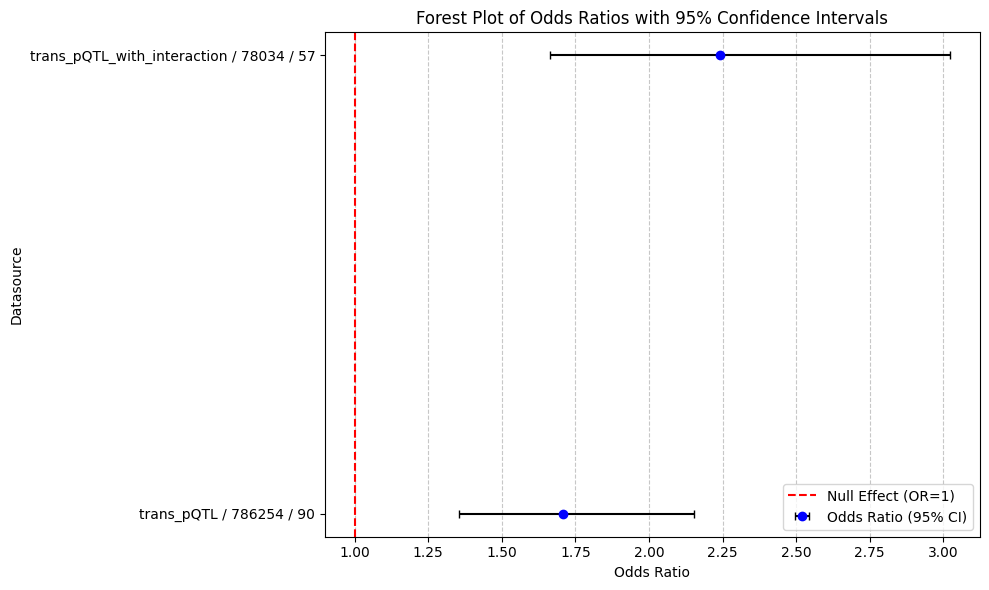

In [36]:
import matplotlib.pyplot as plt

# Assuming `combined_enrich` is your pandas DataFrame
# Sort the DataFrame by odds_ratio for better visualization
combined_enrich_4=combined_enrich[combined_enrich["clinicalPhase"]=="4+"]
combined_enrich_4 = combined_enrich_4.sort_values(by="odds_ratio", ascending=True)

# Extract data for the plot
datasources = combined_enrich_4.apply(
    lambda row: f"{row['datasource']} / {row['total_indirect_assoc']} / {row['yes_evid-high_clinphase']}", axis=1
)
odds_ratios = combined_enrich_4["odds_ratio"]
ci_low = combined_enrich_4["ci_low"]
ci_high = combined_enrich_4["ci_high"]

# Create the forest plot
plt.figure(figsize=(10, 6))
plt.errorbar(odds_ratios, datasources, xerr=[odds_ratios - ci_low, ci_high - odds_ratios], fmt='o', color='blue', ecolor='black', capsize=3, label="Odds Ratio (95% CI)")

# Add labels and title
plt.axvline(x=1, color='red', linestyle='--', label="Null Effect (OR=1)")
plt.xlabel("Odds Ratio")
plt.ylabel("Datasource")
plt.title("Forest Plot of Odds Ratios with 95% Confidence Intervals")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [37]:
folder_to_save="chembl_enrichment/"
combined_enrich.to_csv(folder_to_save+"trans_pQTLs_trans_pQTLs_inter.csv", index=False)